In [2]:
# Reference:
#     gpflow: https://gpflow.readthedocs.io/en/master/notebooks/advanced/gps_for_big_data.html
#             https://github.com/GPflow/GPflow/blob/develop/gpflow/models/sgpr.py#L263
#     julia:  https://github.com/STOR-i/GaussianProcesses.jl/blob/master/src/sparse/fully_indep_train_conditional.jl
#     ladax:  https://github.com/danieljtait/ladax
#

import sys
sys.path.append('../kernel')

import numpy as np
import numpy.random as npr
np.set_printoptions(precision=3,suppress=True)

import jax
from jax import device_put
import jax.numpy as np
import jax.numpy.linalg as linalg

from typing import Any, Callable, Sequence, Optional, Tuple
import flax
from flax import linen as nn
from flax import optim

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import torch
print(torch.cuda.is_available(), jax.devices())

import itertools

import matplotlib.pyplot as plt
import matplotlib as mpl
# https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 25
mpl.rcParams['font.family'] = 'Times New Roman'
cmap = plt.cm.get_cmap('bwr')

from tabulate import tabulate

import sys
sys.path.append('../kernel')
from jaxkern import (cov_se, cov_rq, cov_pe, LookupKernel, normalize_K, mtgp_k)

from plt_utils import plt_savefig, plt_scaled_colobar_ax
from gp import gp_regression_chol, run_sgd
from gpax import log_func_default, log_func_simple, flax_run_optim, CovSE, GPR, GPRFITC


True [CpuDevice(id=0)]


(200, 1) (200, 1)


(-2.0, 2.0)

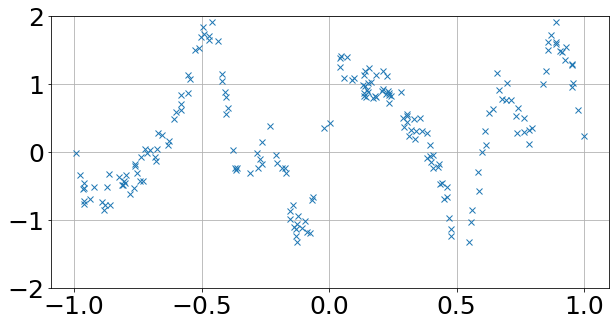

In [4]:

## Parameters 

xlim = (-1, 1)
ylim = (-2, 2)
n_train = 200
n_test = 200
σn = .5
logsn = np.log(σn)
lr = .01
num_steps = 20


## Data

def f_gen(x):
    return np.sin(x * 3 * 3.14) + \
           0.3 * np.cos(x * 9 * 3.14) + \
           0.5 * np.sin(x * 7 * 3.14)

## Plotting

key = jax.random.PRNGKey(0)
npr.seed(0)
X_train = np.expand_dims(npr.uniform(xlim[0], xlim[1], size=n_train), 1)
y_train = f_gen(X_train) + σn * npr.rand(n_train, 1)
data = (X_train, y_train)
X_test  = np.expand_dims(np.linspace(*xlim, n_test), 1)

X_train = device_put(X_train)
y_train = device_put(y_train)
X_test = device_put(X_test)

print(X_train.shape, y_train.shape)


fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(X_train, y_train, 'x', alpha=1)
ax.grid()
ax.set_ylim(ylim)

[  0]	Loss=247.402	σn=1.000
[ 10]	Loss=238.005	σn=0.872
[ 20]	Loss=234.803	σn=0.806
[ 30]	Loss=233.778	σn=0.774
[ 40]	Loss=233.362	σn=0.758
[ 50]	Loss=233.105	σn=0.750
[ 60]	Loss=232.898	σn=0.746
[ 70]	Loss=232.719	σn=0.744
[ 80]	Loss=232.562	σn=0.742
[ 90]	Loss=232.425	σn=0.742
[100]	Loss=232.305	σn=0.741
[110]	Loss=232.203	σn=0.740
[120]	Loss=232.114	σn=0.740
[130]	Loss=232.038	σn=0.740
[140]	Loss=231.971	σn=0.739
[  0]	Loss=247.403	σn=1.000
[ 10]	Loss=233.406	σn=0.909
[ 20]	Loss=233.181	σn=0.911
[ 30]	Loss=232.980	σn=0.914
[ 40]	Loss=232.799	σn=0.916
[ 50]	Loss=232.637	σn=0.919
[ 60]	Loss=232.496	σn=0.922
[ 70]	Loss=232.372	σn=0.924
[ 80]	Loss=232.265	σn=0.927
[ 90]	Loss=232.172	σn=0.929
[100]	Loss=232.092	σn=0.931
[110]	Loss=232.023	σn=0.933
[120]	Loss=231.963	σn=0.935
[130]	Loss=231.911	σn=0.937
[140]	Loss=231.865	σn=0.938


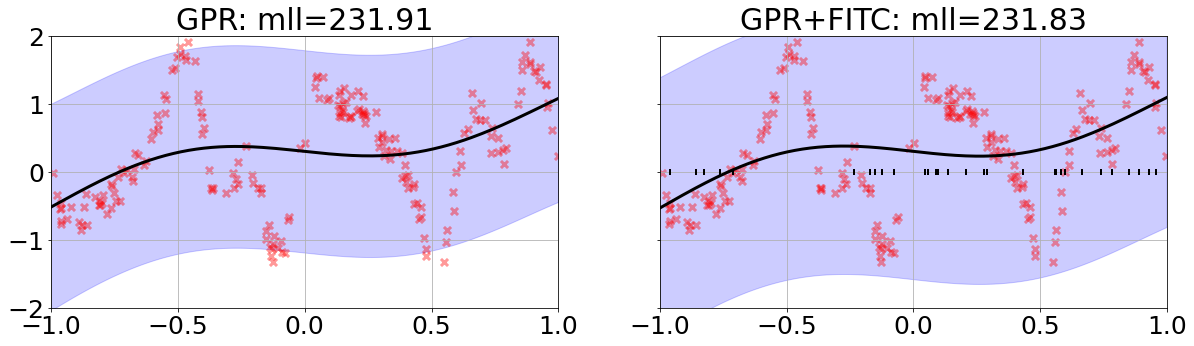

In [5]:
lr = .0002
num_steps = 150
n_inducing = 30


def flax_create_optimizer(params, lr, optimizer='GradientDescent'):
    optimizer_cls = getattr(optim, optimizer)
    return optimizer_cls(learning_rate=lr).create(params)


def flax_run_optim(f, params, lr=.002, num_steps=10,
                   log_func=None,
                   optimizer='GradientDescent'):
    import itertools
#     f = jax.jit(f)
    fg_fn = jax.value_and_grad(f)
    opt = flax_create_optimizer(params, lr=lr, optimizer=optimizer)
    itercount = itertools.count()
    for i in range(num_steps):
        fx, grad = fg_fn(opt.target)
        if log_func is not None: log_func(i, f, opt.target)
        opt = opt.apply_gradient(grad)
    return opt.target

fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharey=True)

def get_model(i):
    if i == 0:
        return 'GPR', GPR(data)
    if i == 1:
        return 'GPR+FITC', GPRFITC(data, n_inducing)
    
    
def log_func(i, f, params):
    if i%10==0:
        print(f'[{i:3}]\tLoss={f(params):.3f}\t'
              f'σn={np.exp(params["params"]["logσn"][0]):.3f}')


for i in range(2):
    name, model = get_model(i)
    params = model.get_init_params(key)
    nmll = lambda params: -model.apply(params, method=model.mll)
    params = flax_run_optim(nmll, params, lr=lr,
                            num_steps=num_steps, log_func=log_func)
    
    mll = model.apply(params, method=model.mll)
    μ, Σ = model.apply(params, X_test, method=model.pred_y)
    std = np.expand_dims(np.sqrt(np.diag(Σ)), 1)

    ax = axs[i]
    ax.plot(X_test, μ, color='k')
    ax.fill_between(X_test.squeeze(), (μ-2*std).squeeze(), (μ+2*std).squeeze(), alpha=.2, color=cmap(0))
    ax.scatter(X_train, y_train, marker='x', color='r', s=50, alpha=.4)
    if i == 1:
        Xu = params['params']['Xu']
        ax.plot(Xu, np.zeros_like(Xu), "k|", mew=2, label="Inducing locations")
    ax.grid()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(f'{name}: mll={-mll:.2f}')
